In [42]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re

# COVID-19 statistics for different countries

## PART 1 — COVID API

In [43]:
def get_covid_cases():
    url = "https://disease.sh/v3/covid-19/countries"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()


    df = pd.DataFrame(data)[['country', 'cases', 'deaths', 'recovered', 'population']]
    print(f"Total countries: {len(df)}")

    df['recovered'] = df['recovered'].fillna(0)


    df = df.dropna(subset=['country', 'cases', 'deaths', 'population'])

   #filter invalid values
    invalid_mask = (
        (df['cases'] < 0) |
        (df['deaths'] < 0) |
        (df['recovered'] < 0) |
        (df['population'] <= 0)
    )

    if invalid_mask.any():
        print(df[invalid_mask][['country', 'cases', 'deaths', 'population']])
        df = df[~invalid_mask]

    df['cases_per_million'] = (df['cases'] / df['population']) * 1_000_000
    df['death_rate_%'] = (df['deaths'] / df['cases']) * 100
    return df


covid_df = get_covid_cases()
print(covid_df.head())

Total countries: 231
              country  cases  deaths  population
56   Diamond Princess    712      13           0
119        MS Zaandam      9       2           0
       country   cases  deaths  recovered  population  cases_per_million  \
0  Afghanistan  234174    7996     211080    40754388        5745.982494   
1      Albania  334863    3605     330233     2866374      116824.601395   
2      Algeria  272010    6881     183061    45350148        5997.995861   
3      Andorra   48015     165          0       77463      619844.312769   
4       Angola  107327    1937     103419    35027343        3064.091958   

   death_rate_%  
0      3.414555  
1      1.076560  
2      2.529686  
3      0.343643  
4      1.804765  


## PART 2 — Web Scraping

In [44]:

def scrape_wikipedia_tables(url, limit=5):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()


    soup = BeautifulSoup(response.text, "html.parser")
    tables = soup.find_all("table", {"class": "wikitable"})
    return tables[:limit]

url = "https://en.wikipedia.org/wiki/Deployment_of_COVID-19_vaccines"

tables = scrape_wikipedia_tables(url)
print("\nPreview table:")
print(tables[0].prettify()[:500])


Preview table:
<table class="wikitable sortable sort-under mw-datatable plainrowheaders sticky-table-row1 sticky-table-col2" style="text-align: right;">
 <caption>
  <a class="mw-selflink selflink">
   COVID-19 vaccine distribution
  </a>
  by country
  <sup class="reference" id="cite_ref-Template:COVID-19_datab_13-0">
   <a href="#cite_note-Template:COVID-19_datab-13">
    <span class="cite-bracket">
     [
    </span>
    12
    <span class="cite-bracket">
     ]
    </span>
   </a>
  </sup>
 </caption>
 <tb


In [45]:
# Extracting data from tables
def extract_vaccine_data(tables):
    vaccination_data = []
    for table_idx, table in enumerate(tables):
        rows = table.find_all("tr")
        if len(rows) < 2:
            continue

        headers = [th.get_text(strip=True).lower() for th in rows[0].find_all(['th', 'td'])]
        country_idx = next((i for i, h in enumerate(headers) if 'location' in h or 'country' in h), None)
        vacc_idx = next((i for i, h in enumerate(headers) if 'vaccinated' in h or 'doses' in h), None)
        percent_idx = next((i for i, h in enumerate(headers) if '%' in h or 'percent' in h), None)

        if country_idx is None:
            continue

        for row in rows[1:]:
            cols = row.find_all(['td', 'th'])
            if len(cols) <= country_idx:
                continue
            try:
                country = re.sub(r'\[.*?\]|\(.*?\)', '', cols[country_idx].get_text(strip=True)).strip()
                if not country:
                    continue
                vaccinated, percent = None, None
                for col_idx in [vacc_idx, percent_idx]:
                    if col_idx is None or col_idx >= len(cols):
                        continue
                    text = cols[col_idx].get_text(strip=True)
                    pct_match = re.search(r'(\d+\.?\d*)\s*%', text)
                    if pct_match:
                        pct = float(pct_match.group(1))
                        if 0 <= pct <= 150:
                            percent = pct
                    num_match = re.search(r'([\d,]+)', text.replace(' ', ''))
                    if num_match:
                        try:
                            num = int(num_match.group(1).replace(',', ''))
                            if num > 1000:
                                vaccinated = num
                        except:
                            pass
                if vaccinated or percent:
                  if country.lower() == 'world':
                        continue
                  vaccination_data.append({
                        'country': country,
                        'vaccinated_count': vaccinated,
                        'vaccination_percent': percent
                    })
            except:
                continue
    return vaccination_data


vacc_data_list = extract_vaccine_data(tables)
print("\nFirst 5 extracted records:")
print(vacc_data_list[:5])


First 5 extracted records:
[{'country': 'China', 'vaccinated_count': 1318026800, 'vaccination_percent': 92.48}, {'country': 'India', 'vaccinated_count': 1027438900, 'vaccination_percent': 72.08}, {'country': 'European Union', 'vaccinated_count': 338481060, 'vaccination_percent': 75.43}, {'country': 'United States', 'vaccinated_count': 270227170, 'vaccination_percent': 79.12}, {'country': 'Indonesia', 'vaccinated_count': 204419400, 'vaccination_percent': 73.31}]


In [46]:
# Cleaning: creating a DataFrame and removing duplicates
def clean_vaccine_data(vaccination_data):
    if not vaccination_data:
        print(" No data to clean")
        return None

    df = pd.DataFrame(vaccination_data)
    df = df.dropna(subset=['vaccinated_count', 'vaccination_percent'], how='all')


    if 'vaccination_percent' in df.columns:
        df = df[
            (df['vaccination_percent'].isna()) |
            ((df['vaccination_percent'] >= 0) & (df['vaccination_percent'] <= 100))
        ]
    df['completeness'] = df.notna().sum(axis=1)
    df = df.sort_values('completeness', ascending=False)
    df = df.drop_duplicates(subset=['country'], keep='first')
    df = df.drop('completeness', axis=1)
    return df

In [47]:
vacc_df = clean_vaccine_data(vacc_data_list)
if vacc_df is not None:
    print("\nTop 10 countries by vaccination percent:")
    display_df = vacc_df.sort_values('vaccination_percent', ascending=False).head(10)
    print(display_df.to_string(index=False))


Top 10 countries by vaccination percent:
             country  vaccinated_count  vaccination_percent
    Pitcairn Islands               NaN               100.00
              Brunei          451149.0                99.07
               Qatar         2852178.0                98.61
                Cuba        10805570.0                97.70
United Arab Emirates         9991089.0                97.55
              Tuvalu            9763.0                97.51
               Macau          679703.0                96.50
             Tokelau            2203.0                95.29
           Nicaragua         6404524.0                95.15
            Portugal         9821414.0                94.28


## PART 3 — Data Merging & Cleaning

In [48]:
# Standardize country names
country_mapping = {
    'United States': 'USA',
    'United Kingdom': 'UK',
    'South Korea': 'S. Korea',
    'United States[g]': 'USA',
}
if vacc_df is not None:
    vacc_df['country'] = vacc_df['country'].replace(country_mapping)


# Check matching
covid_countries = set(covid_df['country'].unique())
vacc_countries = set(vacc_df['country'].unique())
matching = covid_countries.intersection(vacc_countries)

print(f"COVID data: {len(covid_countries)} countries")
print(f"Vaccine data: {len(vacc_countries)} countries")
print(f"Matching: {len(matching)} countries")

COVID data: 229 countries
Vaccine data: 220 countries
Matching: 195 countries


### Merge datasets

In [49]:
merged = pd.merge(
    covid_df,
    vacc_df,
    on="country",
    how="inner"
)

print("\nMerged data:")
print(merged.head(10))



Merged data:
               country     cases  deaths  recovered  population  \
0          Afghanistan    234174    7996     211080    40754388   
1              Albania    334863    3605     330233     2866374   
2              Algeria    272010    6881     183061    45350148   
3              Andorra     48015     165          0       77463   
4               Angola    107327    1937     103419    35027343   
5             Anguilla      3904      12          0       15230   
6  Antigua and Barbuda      9106     146       8954       99509   
7            Argentina  10128845  130841    9997258    46010234   
8              Armenia    451831    8777     435162     2971966   
9                Aruba     44224     292      42438      107609   

   cases_per_million  death_rate_%  vaccinated_count  vaccination_percent  
0        5745.982494      3.414555        19151368.0                47.20  
1      116824.601395      1.076560         1349255.0                47.72  
2        5997.995861

In [50]:
# Save merged data
merged.to_csv("covid_vaccine_merged.csv", index=False)
print("\n Merged data saved to covid_vaccine_merged.csv")


 Merged data saved to covid_vaccine_merged.csv


## PART 4 — Exploratory Data Analysis


Top 10 countries by vaccination percentage:
       country  vaccination_percent  cases_per_million  death_rate_%
27      Brunei                99.07      771654.869104      0.065460
139      Qatar                98.61      172663.985382      0.134105
45        Cuba                97.70       98645.438582      0.764850
181     Tuvalu                97.51      243908.503232      0.033979
175    Tokelau                95.29       58055.152395      0.000000
124  Nicaragua                95.15        2727.648213      1.216808
138   Portugal                94.28      556483.708509      0.498417
120      Nepal                93.83       33198.699036      1.198964
155  Singapore                93.58      505784.762161      0.067329
169     Taiwan                93.51      428720.190534      0.185568


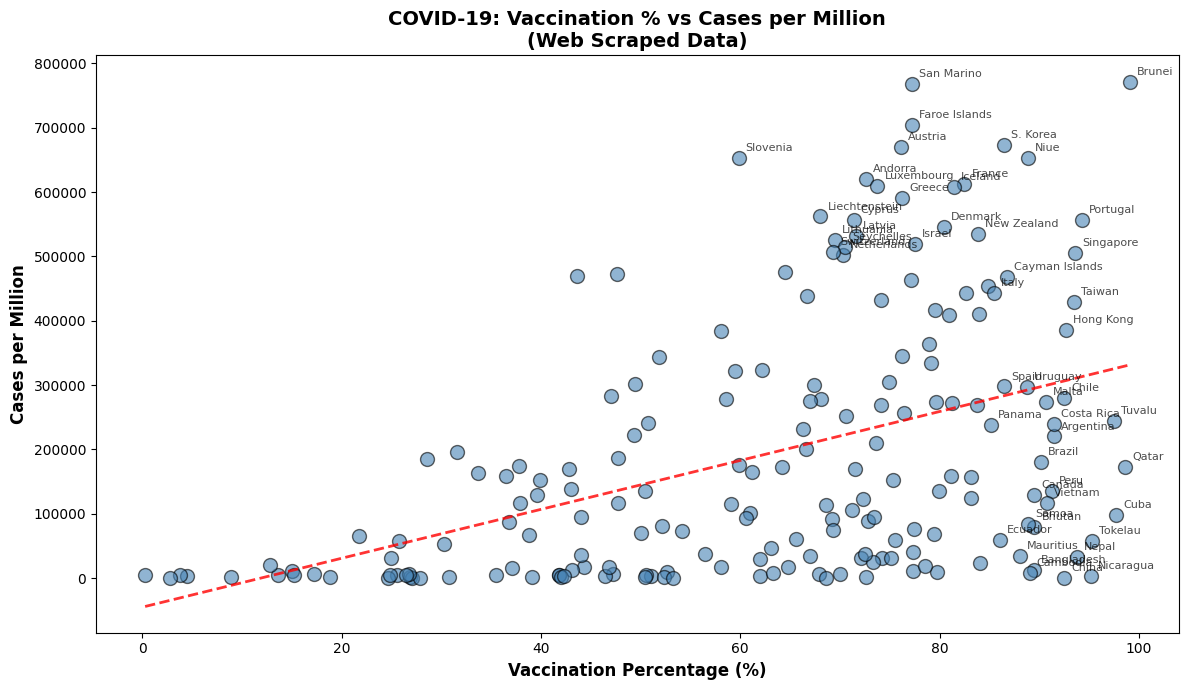

In [51]:
top_vacc = merged.sort_values('vaccination_percent', ascending=False).head(10)
print("\nTop 10 countries by vaccination percentage:")
print(top_vacc[['country', 'vaccination_percent', 'cases_per_million', 'death_rate_%']])



plt.figure(figsize=(12, 7))
plt.scatter(
    merged['vaccination_percent'],
    merged['cases_per_million'],
    s=100, alpha=0.6, color='steelblue', edgecolors='black'
)

import numpy as np
z = np.polyfit(merged['vaccination_percent'], merged['cases_per_million'], 1)
p = np.poly1d(z)
x_trend = np.linspace(
    merged['vaccination_percent'].min(),
    merged['vaccination_percent'].max(), 100
)
plt.plot(x_trend, p(x_trend), "r--", linewidth=2, alpha=0.8, label='Trend line')


for idx, row in merged.iterrows():
    if row['cases_per_million'] > 500000 or row['vaccination_percent'] > 85:
        plt.annotate(
            row['country'],
            (row['vaccination_percent'], row['cases_per_million']),
            xytext=(5, 5), textcoords='offset points',
            fontsize=8, alpha=0.7
        )

plt.xlabel("Vaccination Percentage (%)", fontsize=12, fontweight='bold')
plt.ylabel("Cases per Million", fontsize=12, fontweight='bold')
plt.title(
    "COVID-19: Vaccination % vs Cases per Million\n(Web Scraped Data)",
    fontsize=14, fontweight='bold'
)
plt.tight_layout()
plt.show()




Red dotted line shows positive correlations between Vaccination percentage and Cases per million.  But it does not mean that vaccines are not effective and insrease cases.
Possible reasons:
1)Countries with high vaccination rates usually have a better healthcare system → more testing → more cases detected
2)After vaccination, countries eased restrictions → more contacts → more cases (but less severe)

In [56]:
from scipy import stats
if len(merged) > 10:
  corr, p_value = stats.pearsonr(merged['vaccination_percent'],
                                          merged['cases_per_million'])
  print(f"\nCorrelation (Vaccination vs Cases): r = {corr:.3f}, p = {p_value:.10f}")
  corr2, p_value2 = stats.pearsonr(merged['vaccination_percent'],
                                            merged['death_rate_%'])
  print(f"Correlation (Vaccination vs Death Rate): r = {corr2:.3f}, p = {p_value2:.10f}")


Correlation (Vaccination vs Cases): r = 0.438, p = 0.0000000001
Correlation (Vaccination vs Death Rate): r = -0.367, p = 0.0000001275


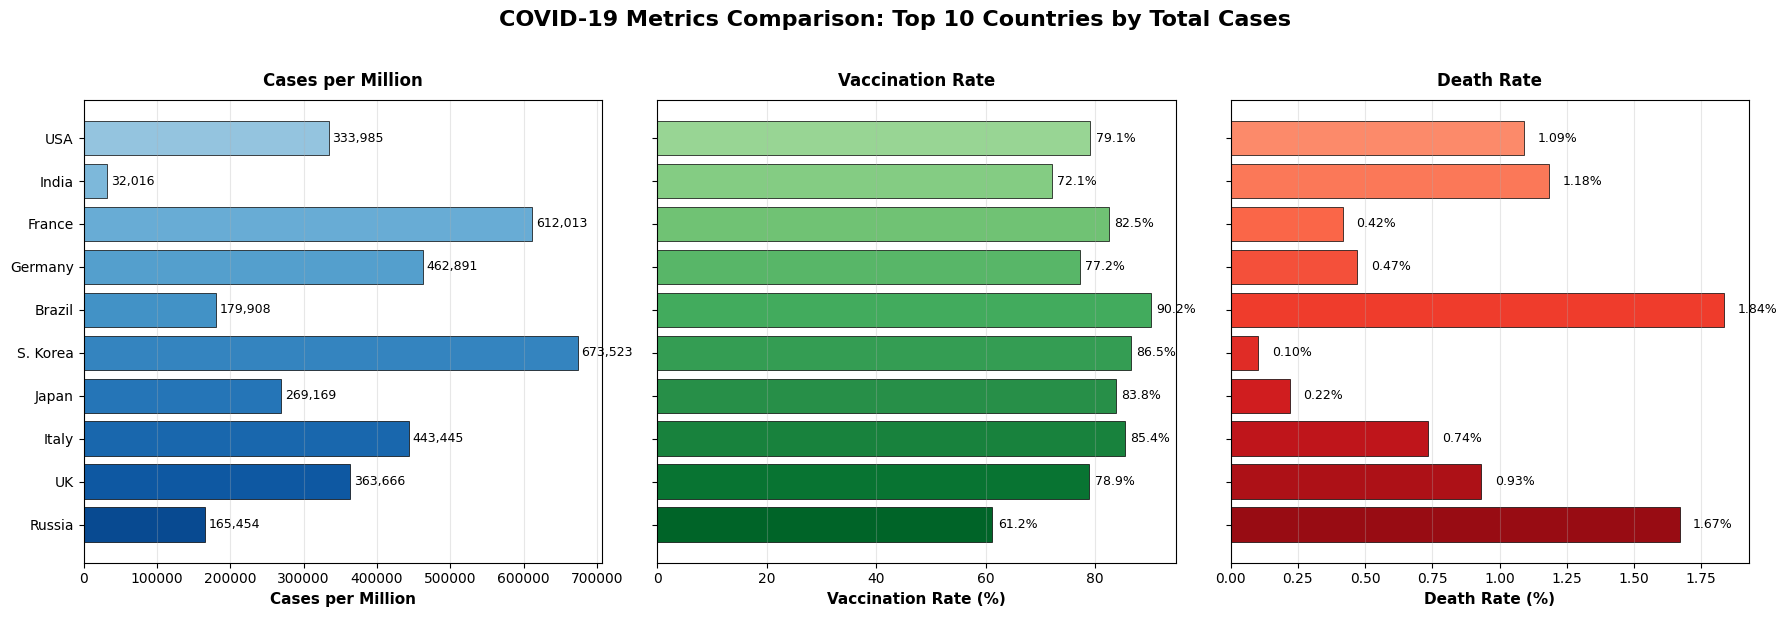

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
top_countries = merged.nlargest(10, 'cases')

# Cases per Million
ax1 = axes[0]
colors_cases = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_countries)))
bars1 = ax1.barh(range(len(top_countries)),
                 top_countries['cases_per_million'],
                 color=colors_cases, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(top_countries)))
ax1.set_yticklabels(top_countries['country'], fontsize=10)
ax1.set_xlabel('Cases per Million', fontsize=11, fontweight='bold')
ax1.set_title('Cases per Million', fontsize=12, fontweight='bold', pad=10)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 5000, bar.get_y() + bar.get_height()/2,
            f'{width:,.0f}', ha='left', va='center', fontsize=9)

# Vaccination Rate
ax2 = axes[1]
colors_vacc = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_countries)))
bars2 = ax2.barh(range(len(top_countries)),
                 top_countries['vaccination_percent'],
                 color=colors_vacc, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(top_countries)))
ax2.set_yticklabels([])
ax2.set_xlabel('Vaccination Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('Vaccination Rate', fontsize=12, fontweight='bold', pad=10)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%', ha='left', va='center', fontsize=9)

# Death Rate
ax3 = axes[2]
colors_death = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_countries)))
bars3 = ax3.barh(range(len(top_countries)),
                 top_countries['death_rate_%'],
                 color=colors_death, edgecolor='black', linewidth=0.5)
ax3.set_yticks(range(len(top_countries)))
ax3.set_yticklabels([])
ax3.set_xlabel('Death Rate (%)', fontsize=11, fontweight='bold')
ax3.set_title('Death Rate', fontsize=12, fontweight='bold', pad=10)
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width + 0.05, bar.get_y() + bar.get_height()/2,
            f'{width:.2f}%', ha='left', va='center', fontsize=9)

plt.suptitle('COVID-19 Metrics Comparison: Top 10 Countries by Total Cases',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

plt.show()



#### 1. South Korea vs Brazil: The Quality of Healthcare Matters

Comparison of two countries with high vaccination rates:
-  **South Korea**: 673k cases/M, 86.5% vaccination, **0.10% deaths**
-  **Brazil**: 180k cases/M, 90.2% vaccination, **1.84% deaths**

Brazil has higher vaccination coverage, but death rate is **18 times higher** than South Korea!

**Why?** Vaccination alone is not enough. Other important factors:
- Quality of healthcare system
- When vaccination started (timing relative to infection waves)
- Population demographics (age distribution)

#### 2. USA vs India: Testing Makes a Big Difference

-  **USA**: 334,000 cases per million
-  **India**: 32,000 cases per million (10x lower)

This doesn't mean India handled the pandemic better. The difference is mainly due to:
- **USA**: Extensive testing → more detected cases
- **India**: Limited testing access → many undetected cases (underreporting)

#### 3. Visual Pattern: Vaccination and Death Rate

Looking at the middle and right panels together:
- High vaccination (long green bar) usually means low death rate (short red bar)
- Low vaccination (short green bar) usually means high death rate (long red bar)

**Exception:** Brazil breaks this pattern - high vaccination but still high death rate.



### Main Takeaways

1. **Cases per million is misleading**
   - Depends heavily on how much testing is done
   - South Korea's high number (673k) reflects good testing, not worse outcomes

2. **Death rate is the metric that matters**
   - Less affected by testing differences between countries
   - Better indicator of actual pandemic impact

3. **Vaccination works, but isn't everything**
   - Brazil: 90% vaccinated but 1.84% death rate
   - South Korea: 86.5% vaccinated but only 0.10% death rate
   - The difference? Healthcare infrastructure and pandemic management

4. **Best results need multiple factors**
   - South Korea's success: testing + vaccination + good healthcare = 0.10% mortality

 High vaccination rates help, but countries also need strong healthcare systems and effective pandemic response to minimize deaths.

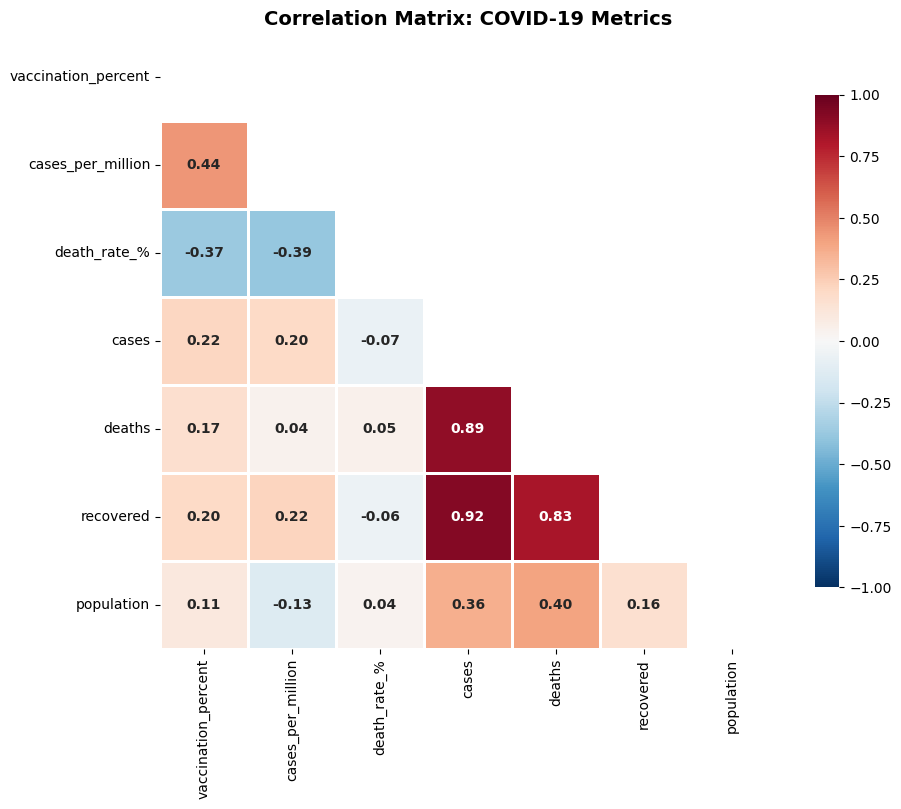

In [54]:
import seaborn as sns

corr_cols = ['vaccination_percent', 'cases_per_million', 'death_rate_%',
             'cases', 'deaths', 'recovered', 'population']
corr_matrix = merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, square=True,
            linewidths=2, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1,
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Correlation Matrix: COVID-19 Metrics', fontsize=14, fontweight='bold')
plt.show()



**Strong connections:**
- Where there are more cases → more deaths (0.89) and recoveries (0.92)
- This is logical, because all these indicators are growing together

**Vaccination:**
- The higher the vaccination → the lower the mortality rate (-0.37, -0.39)
- It is clear that vaccinations work
- But the connection with cases is weak (-0.07) - it is possible that regions with problems were vaccinated more actively

**Population:**
- The size of the population has almost no effect on the indicators (all correlations are weak)
- This means that small and large regions suffered differently.

Correlation shows a connection, but not a cause. For accurate conclusions, a deeper analysis is needed.

##PART 5 — Summary Statistics

In [55]:
print(f"\nCOVID-19 Dataset:")
print(f"  Total countries: {len(covid_df)}")
print(f"  Total cases: {covid_df['cases'].sum():,.0f}")
print(f"  Total deaths: {covid_df['deaths'].sum():,.0f}")
print(f"  Average death rate: {covid_df['death_rate_%'].mean():.2f}%")

if len(merged) > 0:
    print(f"\nMerged Dataset (with vaccination data):")
    print(f"  Countries with both datasets: {len(merged)}")
    if 'vaccination_percent' in merged.columns:
        print(f"  Average vaccination rate: {merged['vaccination_percent'].mean():.1f}%")



COVID-19 Dataset:
  Total countries: 229
  Total cases: 704,753,169
  Total deaths: 7,010,666
  Average death rate: 1.29%

Merged Dataset (with vaccination data):
  Countries with both datasets: 195
  Average vaccination rate: 62.4%
